In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from nltk.corpus import stopwords
#!python -m spacy download en_core_web_sm
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.font_manager as fm

In [2]:
df = pd.read_csv('') # Insert dataset.csv path here
df.head()

,row_index,Act Number,chapter_index,chapter,dialogue_index,line_index,speaker,line,happiness,ambitious,surprise,anger,sadness,fear,neutral
0,0,1,0,The Gommage,0,0,Maelle,"If you’re gonna give someone flowers, you shou...",0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,1,0,The Gommage,0,1,Gustave,"What, the flower? Or Sophie?",0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,1,0,The Gommage,0,2,Maelle,"Ooh, dark. Sophie would approve. Hey, you said...",0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,1,0,The Gommage,0,3,Gustave,With what? Putting three tables? They’ll manage.,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,1,0,The Gommage,0,4,Maelle,Ah. You underestimate Lumière’s enthusiasm for...,0.0,0.0,0.0,0.0,0.0,0.0,1.0


First of all, let's start by trying to get a general feel of the script. We will use TF-IDF to identify words and bigrams that appear a lot of times overall but concentrated in just a few lines, filtering out common stopwords and profanity. This should give us an idea of the most important concepts and themes in the script.

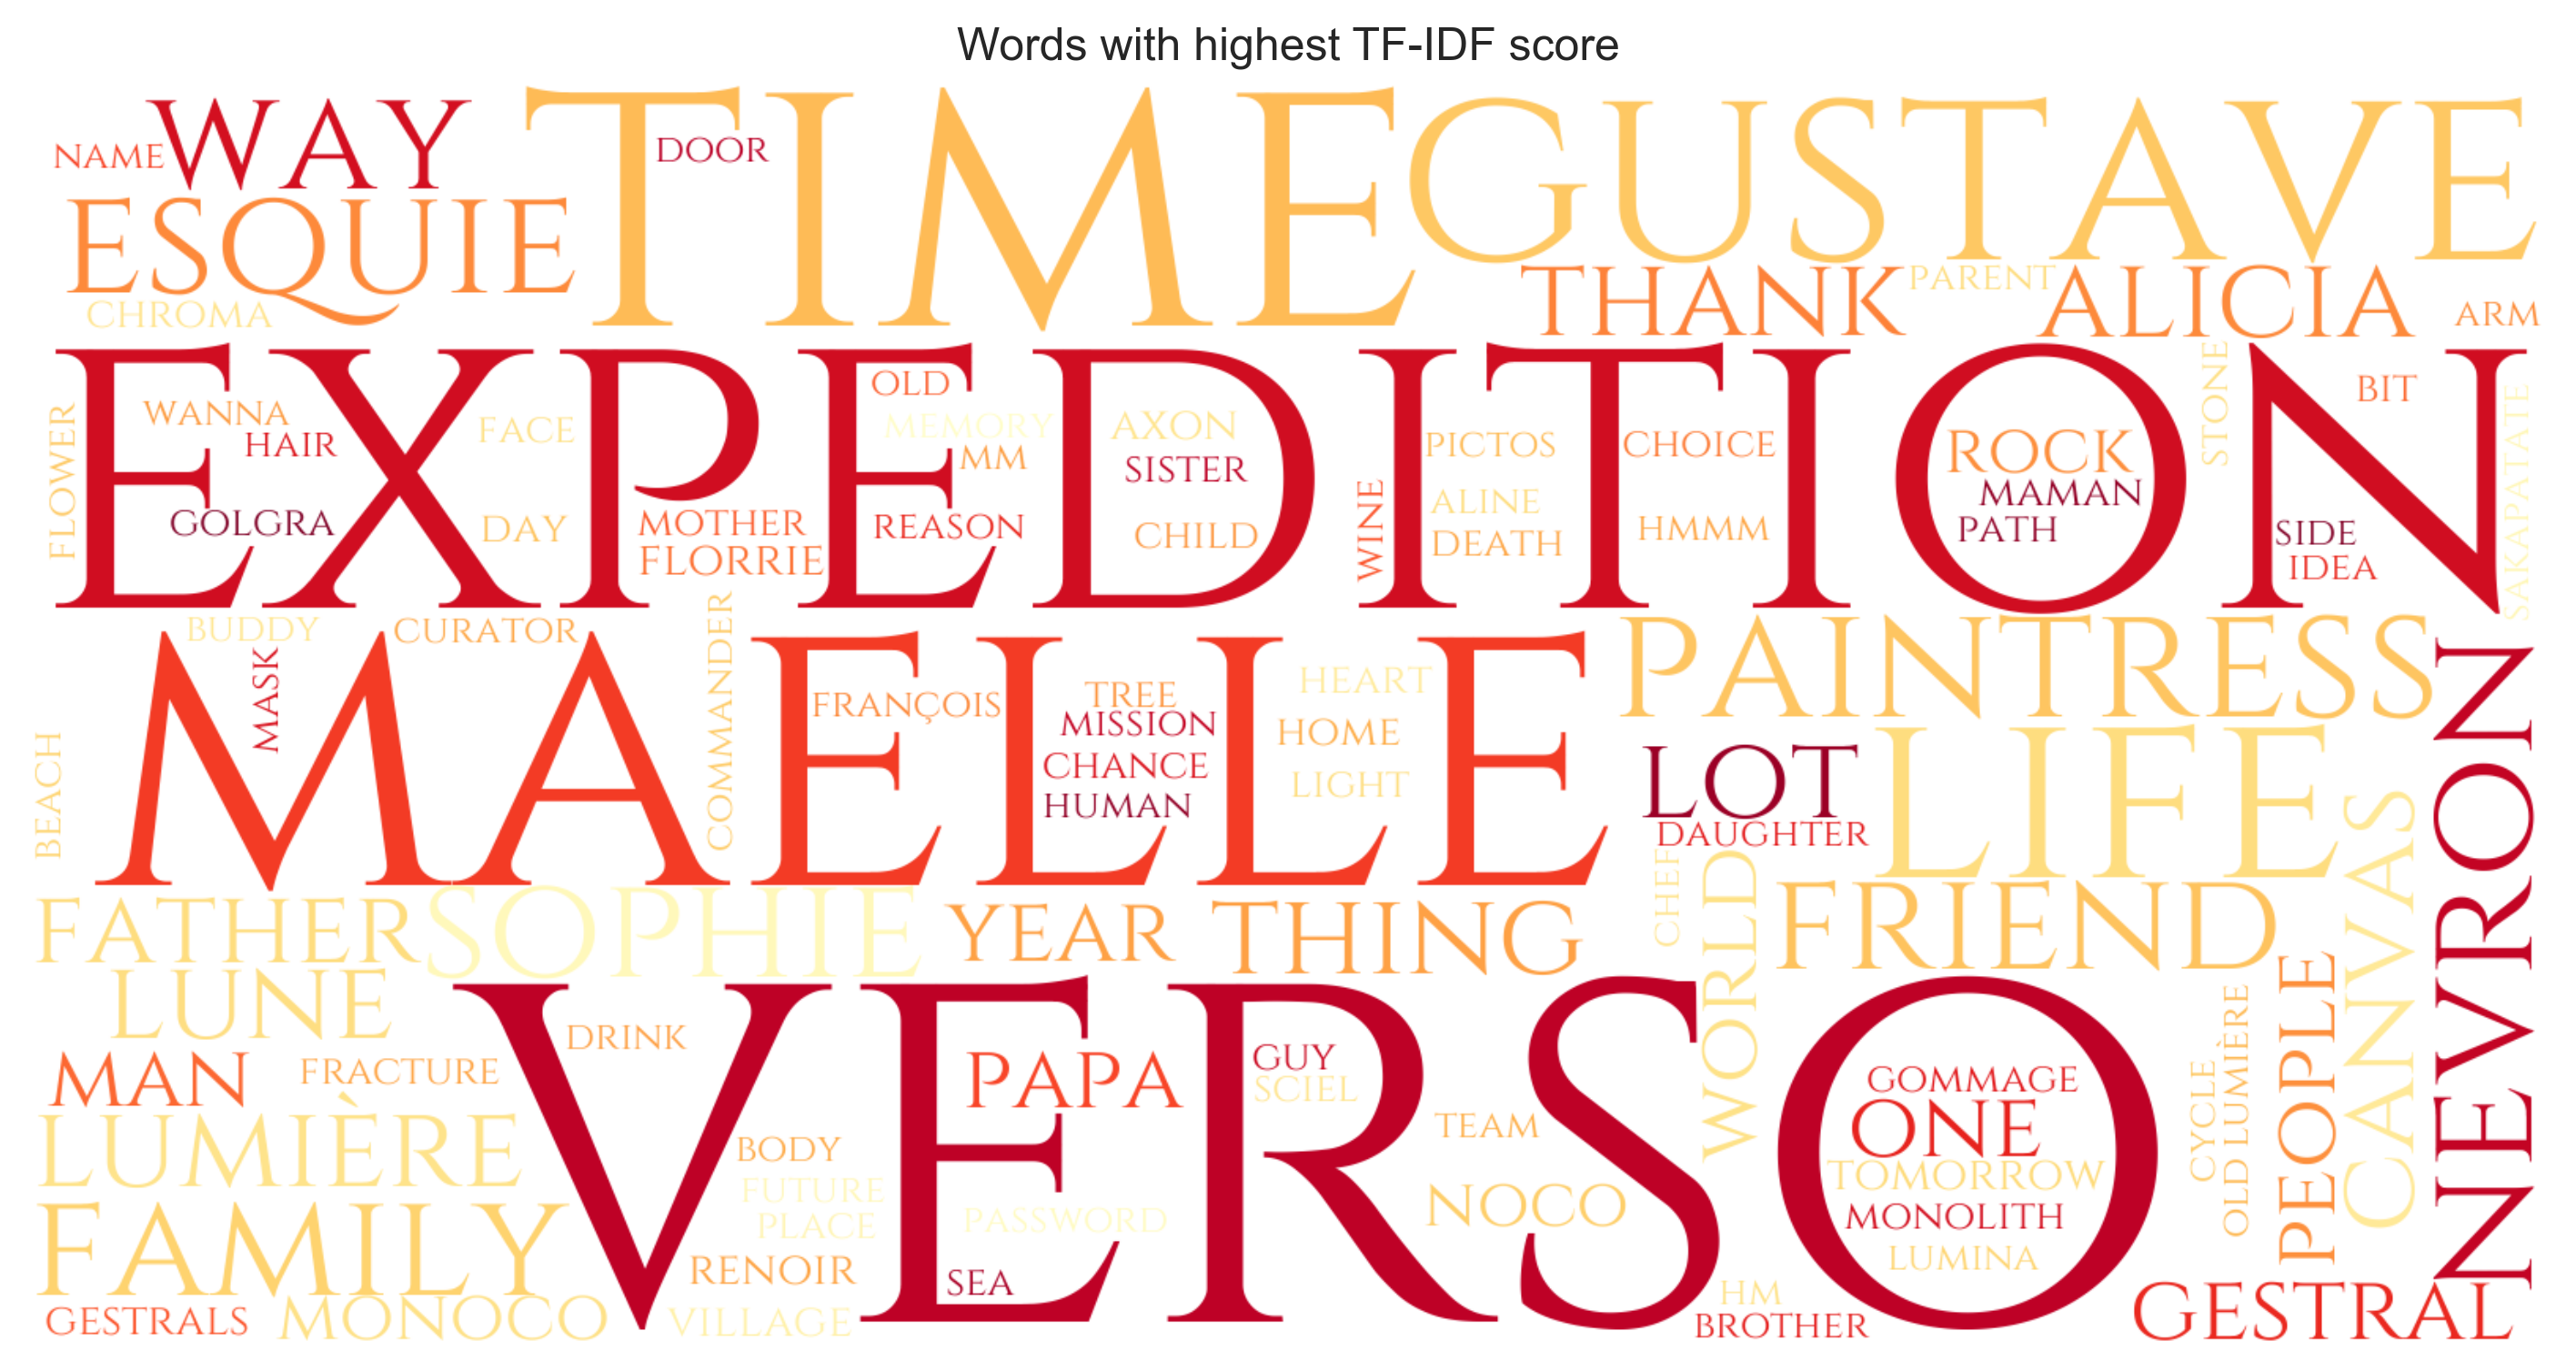

In [33]:
stop_words = set(stopwords.words('english'))
custom_stopwords = {"yeah", "oh", "uh", "um", "well", "right", "okay", "ok", "gonna", "gibberish", "huh"}
profanity_list = {"fuck", "shit", "bitch", "ass", "damn", "crap", "merde", "putain"}
stop_words |= profanity_list
stop_words |= custom_stopwords

nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    doc = nlp(text)
    allowed_pos = {"NOUN", "PROPN"}
    return [
        token.lemma_.lower()
        for token in doc
        if token.is_alpha and token.pos_ in allowed_pos and token.lemma_.lower() not in stop_words
    ]

processed_lines = [" ".join(preprocess(line)) for line in df['line']]

vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(processed_lines)
feature_names = vectorizer.get_feature_names_out()

tfidf_sums = np.array(tfidf_matrix.sum(axis=0)).flatten()

top_n = 100
top_indices = tfidf_sums.argsort()[-top_n:][::-1]
top_words = [(feature_names[idx], tfidf_sums[idx]) for idx in top_indices]

def plot_tfidf_wordcloud(top_words, title):
    freq_dict = {word: score for word, score in top_words}
    wc = WordCloud(width=1600, height=800, background_color='white', font_path='', colormap='YlOrRd').generate_from_frequencies(freq_dict) # Insert font path
    plt.figure(figsize=(12, 6), dpi=300)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_tfidf_wordcloud(top_words, "Words with highest TF-IDF score", )


Now that we have a general understanding of the main themes of the script, we can try to see if the main characters can emerge from computational methods. Since there are a lot of speakers with only a few lines, we will only focus on those with at least 1.5 times the median number of lines for each speaker.

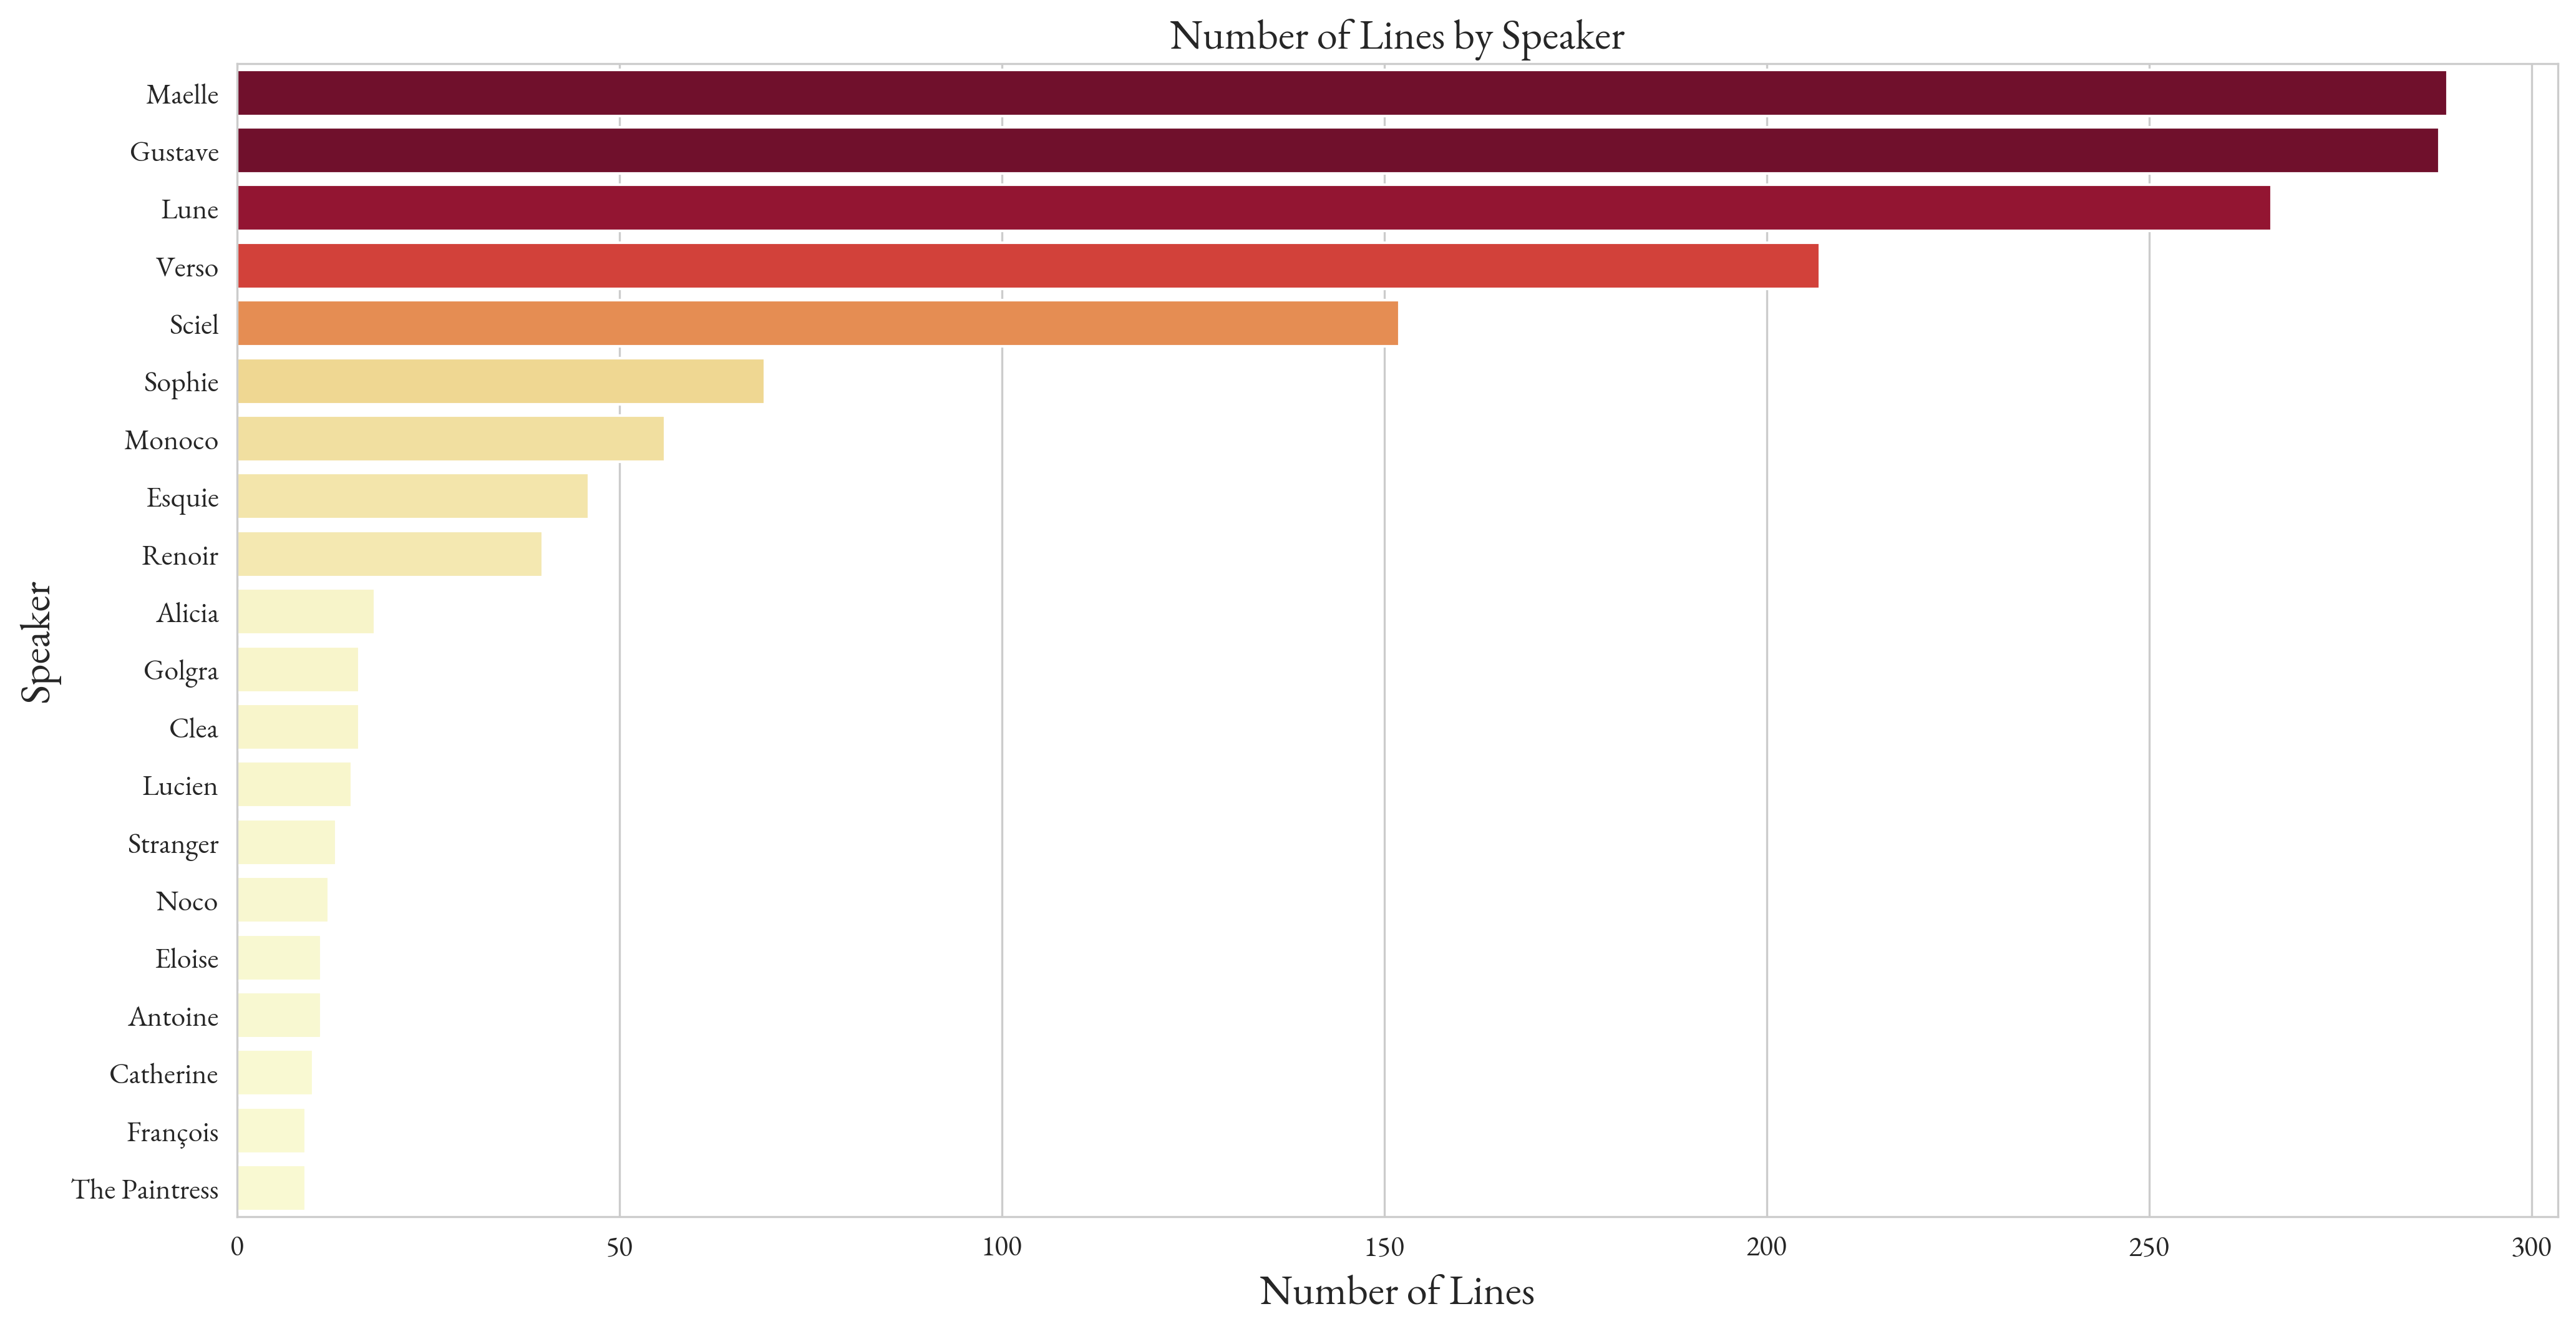

In [90]:
speaker_counts = df['speaker'].value_counts()
speaker_counts = speaker_counts[speaker_counts >= speaker_counts.median() * 1.5]
font_path = ''  # Font path here
font_prop = fm.FontProperties(fname=font_path, size=16)
fm.fontManager.addfont(font_path)

sns.set_style({'font.family': 'EB Garamond', 'font.size': 22})

plt.figure(figsize=(16, 8), dpi=300)
sns.barplot(x=speaker_counts.values, y=speaker_counts.index, palette='YlOrRd', hue=speaker_counts)
plt.title('Number of Lines by Speaker', fontproperties=font_prop)
plt.xlabel('Number of Lines', fontproperties=font_prop)
plt.ylabel('Speaker', fontproperties=font_prop)
plt.legend().remove()
plt.show()

Let's analyze when the characters in this subset make their appearances throughout the script.

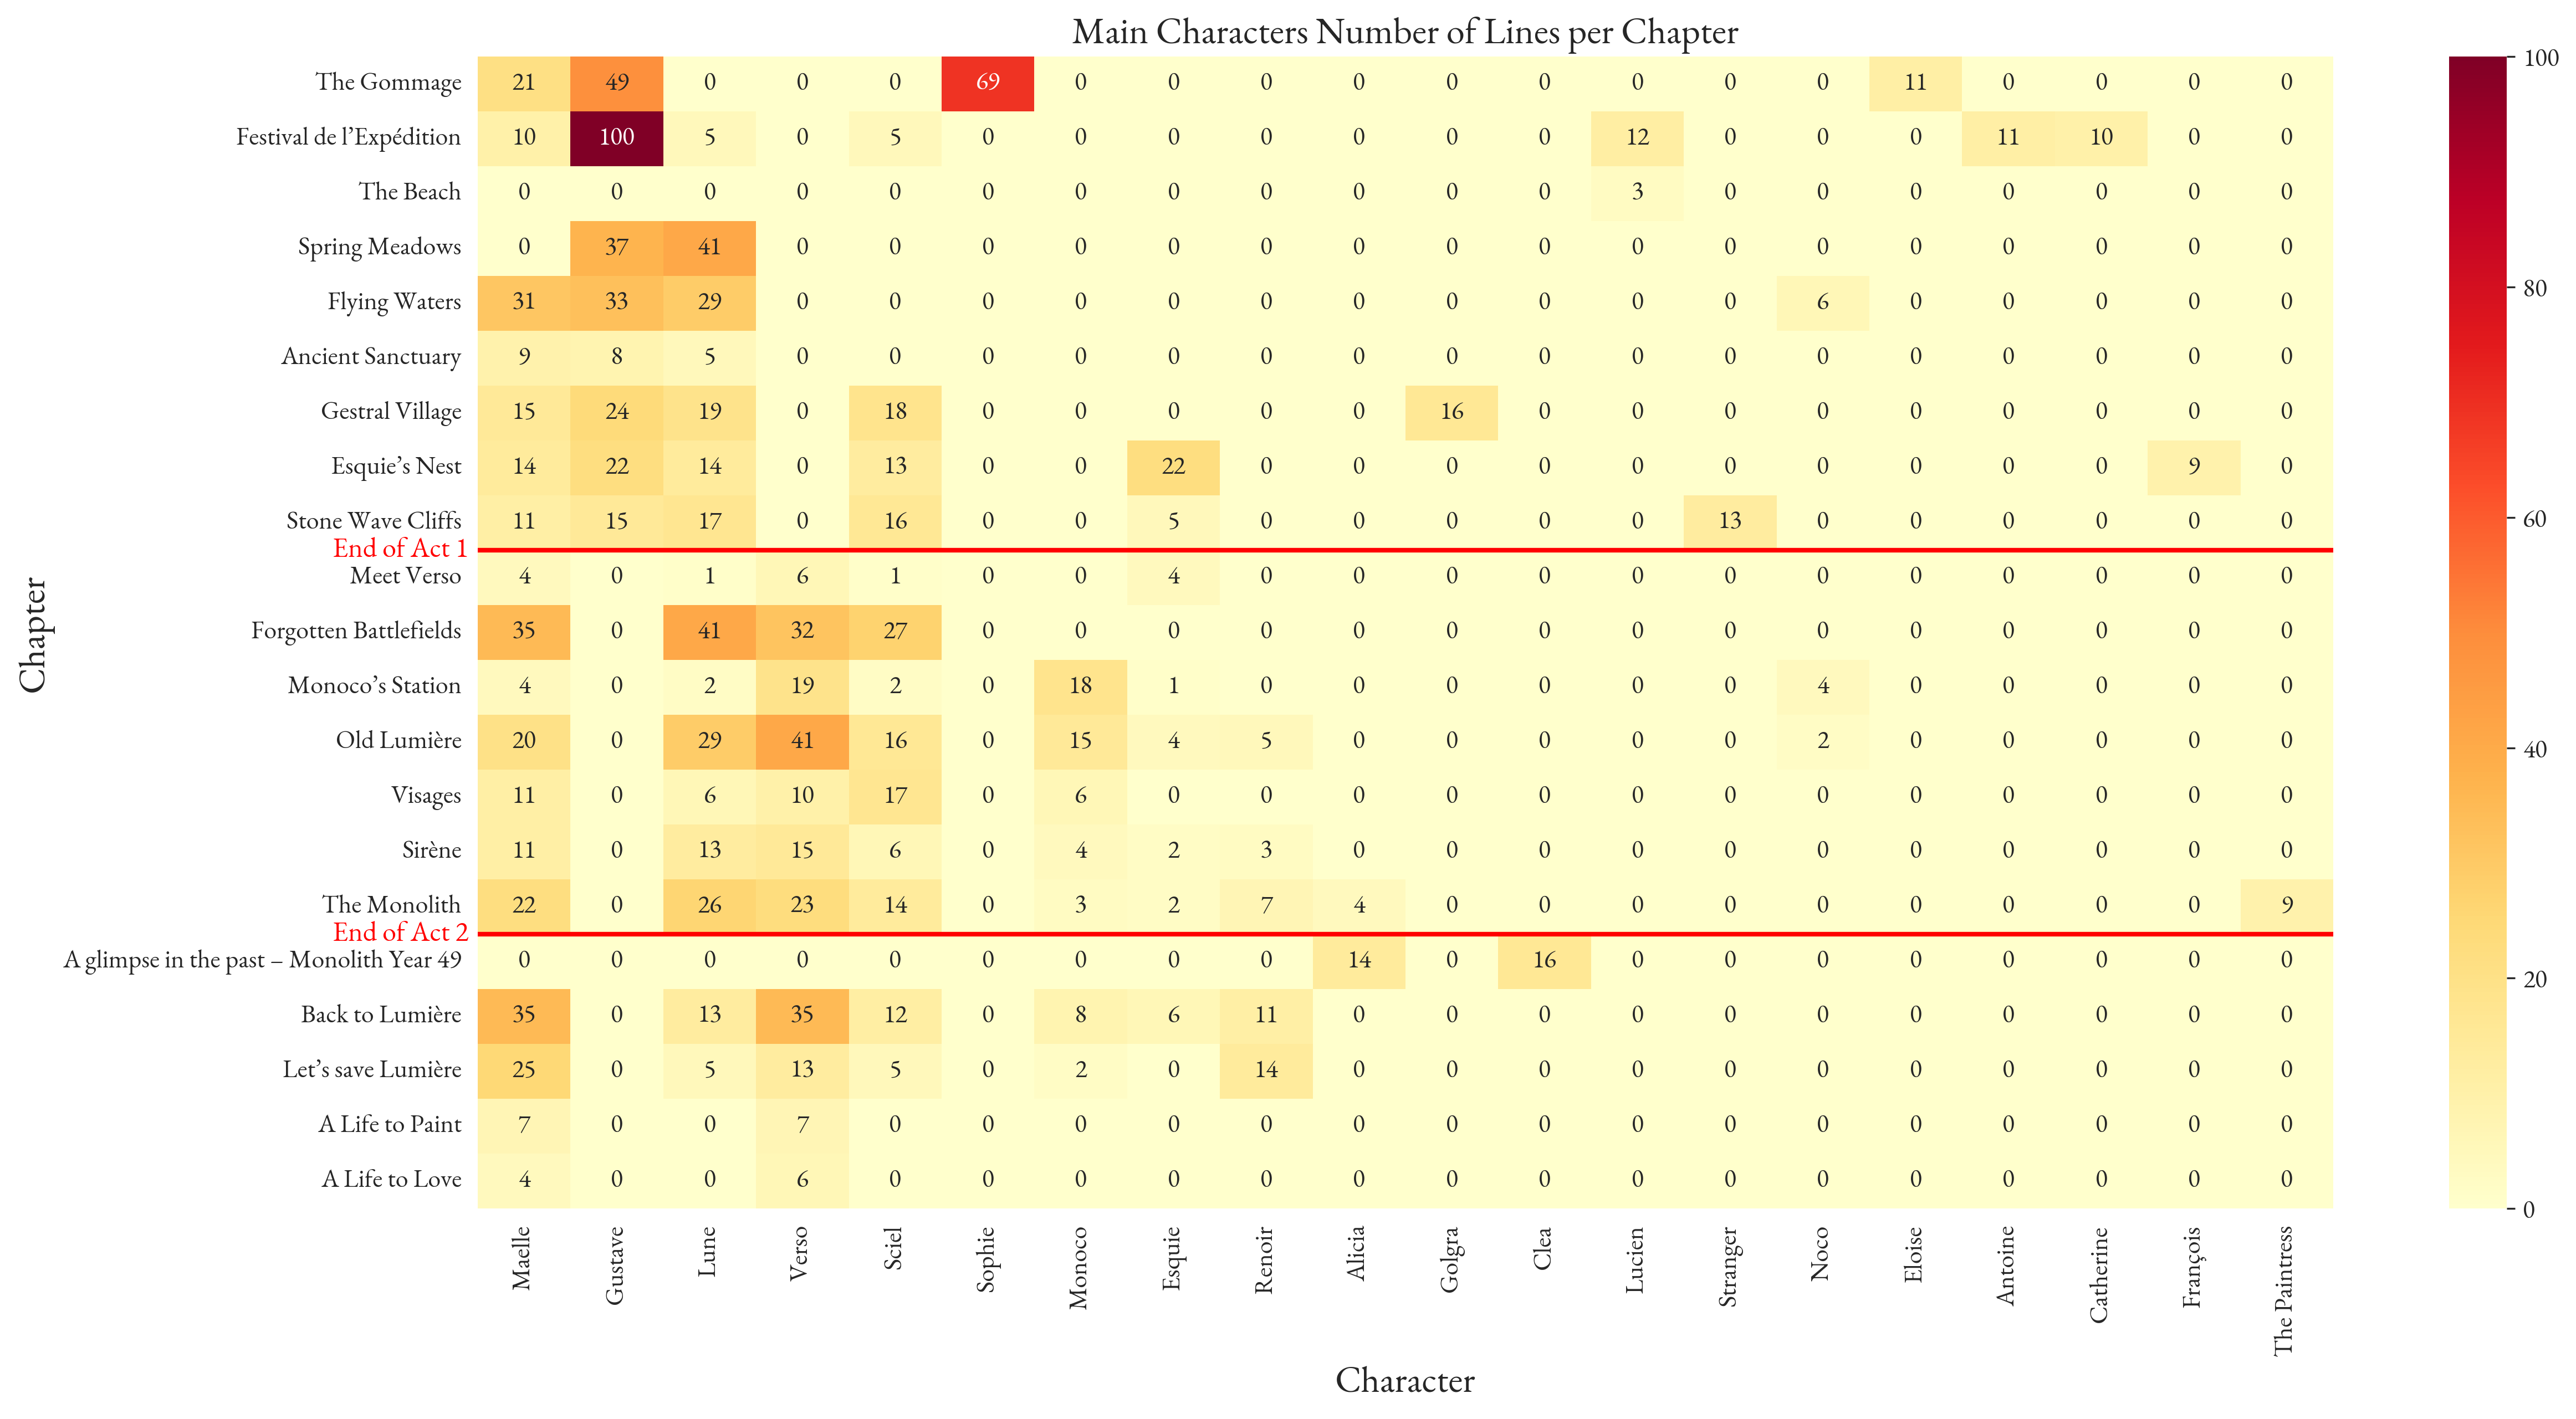

In [91]:
character_subset_names = speaker_counts.index.tolist()

chapter_line_counts = pd.DataFrame(0, index=character_subset_names, columns=df['chapter'].unique())

for character in character_subset_names:
    character_dialogues = df[df['speaker'] == character]
    chapter_counts = character_dialogues['chapter'].value_counts()
    for chapter, count in chapter_counts.items():
        chapter_line_counts.at[character, chapter] = count

plt.figure(figsize=(18, 9), dpi=300)
ax = sns.heatmap(chapter_line_counts.T, annot=True, fmt='d', cmap='YlOrRd')

plt.title('Main Characters Number of Lines per Chapter', fontproperties=font_prop)
plt.ylabel('Chapter', fontproperties=font_prop)
plt.xlabel('Character', fontproperties=font_prop)


chapter_act_map = df.groupby('chapter')['Act Number'].first().reindex(chapter_line_counts.columns)

act_changes = []
for i in range(1, len(chapter_act_map)):
    if chapter_act_map.iloc[i] != chapter_act_map.iloc[i-1]:
        act_changes.append(i)

for pos in act_changes:
    previous_act = chapter_act_map.iloc[pos-1]
    y = pos

    plt.axhline(y, color='red', linewidth=2)

    plt.text(
        -0.1,
        y,
        f"End of Act {previous_act}",
        color='red',
        va='center',
        ha='right',
        fontsize=12,
        fontweight='bold',
        fontproperties=font_prop,
    )
plt.show()

With this information, we could make some reasonable assumptions about who the main characters are. From our analysis, the most prominent characters appear to be:
- Maelle
- Gustave
- Lune
- Verso
- Sciel
- Monoco
- Esquie
- Renoir
- Alicia

Some characters only show up in the first chapters, others have generic names like "Stranger", so we can exclude them from the main cast. Sophie seems to be the odd one out, as she has a significant number of lines but only appears in the first chapter. Other honorable mentions might include characters with a significant number of lines but limited appearances only in the later chapters, such as Clea. Also The Paintress, appearing exactly at the end of Act 2 and disappearing right after, plays a crucial role in the plot.

In [92]:
main_character_names = ["Maelle", "Gustave", "Lune", "Sciel", "Monoco", "Esquie", "The Paintress", "Verso", "Alicia", "Renoir", "Clea", "Sophie"]

Now that we have narrowed down our list of main characters, we can analyze the relationships between them. We will use cosine similarity on TF-IDF vectors of their dialogues to determine how similar their lines are to each other. This can give us insights into which characters might have similar roles or personalities in the story.

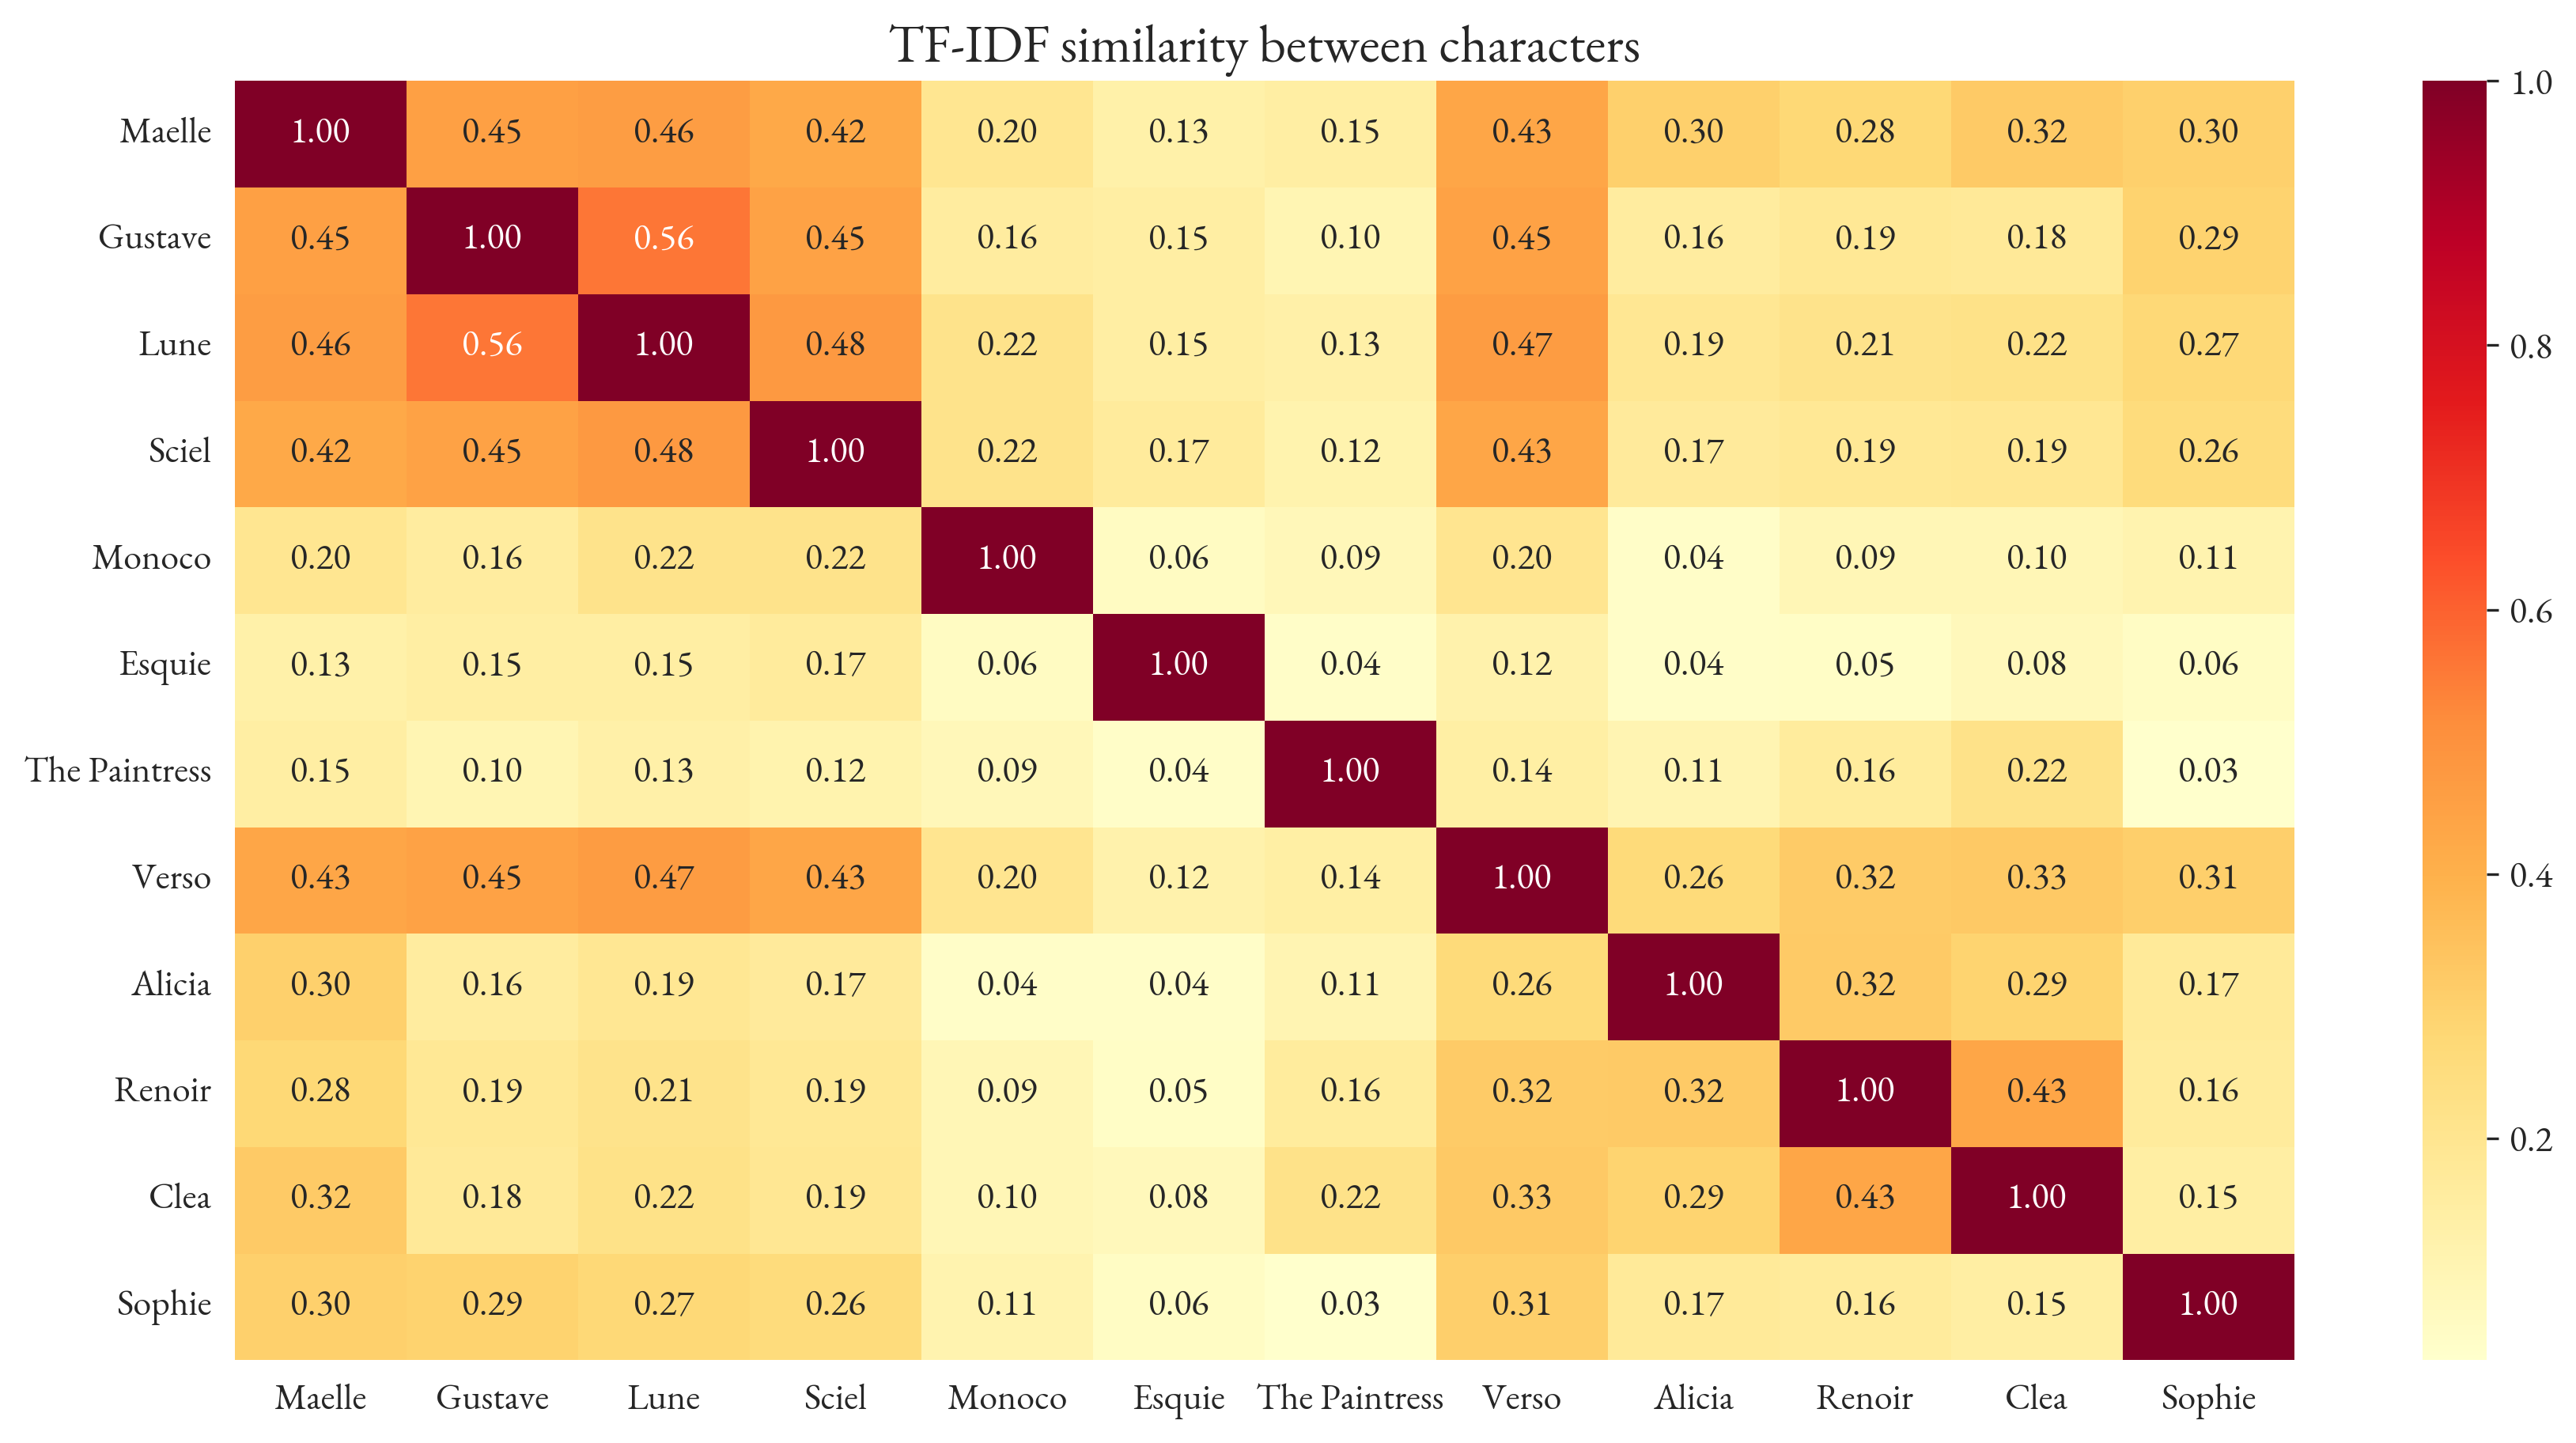

In [93]:
docs = []
characters = []

def preprocess(text):
    doc = nlp(text)
    allowed_pos = {"NOUN", "PROPN", "VERB"}
    return [
        token.lemma_.lower()
        for token in doc
        if token.is_alpha and token.pos_ in allowed_pos and token.lemma_.lower() not in stop_words
    ]

for character in main_character_names:
    lines = df[df['speaker'] == character]['line']
    text = " ".join([" ".join(preprocess(line)) for line in lines])
    docs.append(text)
    characters.append(character)

vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
tfidf_matrix = vectorizer.fit_transform(docs)
feature_names = vectorizer.get_feature_names_out()

similarity_matrix = cosine_similarity(tfidf_matrix)

plt.figure(figsize=(14, 7), dpi=300)
sns.heatmap(similarity_matrix, xticklabels=characters, yticklabels=characters,
            cmap="YlOrRd", annot=True, fmt=".2f")
plt.title("TF-IDF similarity between characters", fontproperties=font_prop)
plt.yticks(rotation=0)
plt.show()

We can clearly see that the stronges similarities are between Maelle, Gustave, Lune, Sciel and Verso, all of which we know to be the main characters of the story. Monoco and Esquie do, to a lesser extent, show similarities with the main party, and this is also expected since they are deuteragonists.

Another interesting cluster is formed by Alicia, Renoir, Clea, to a lesser degree The Paintress and, oddly enough, Verso. Being the antagonists, most of these character don't share strong similarities with the main party. The only exception is Verso, torn between his secret family and the Expedition, thus the similarities with both sides.

Lastly, Sophie seems to be somewhat related to the main party, but we know that she only appears in the first chapter, and is the speaker with the highest number of lines in that chapter.

### Evaluating plot sentiment over time
We will now perform sentiment analysis on the dialogues to see how the sentiment changes over the course of the story. We will use VADER sentiment analysis to compute a sentiment score for each dialogue, and then plot these scores over time to see if there are any noticeable trends or patterns, using a moving average to smooth out short-term fluctuations and highlight longer-term trends.

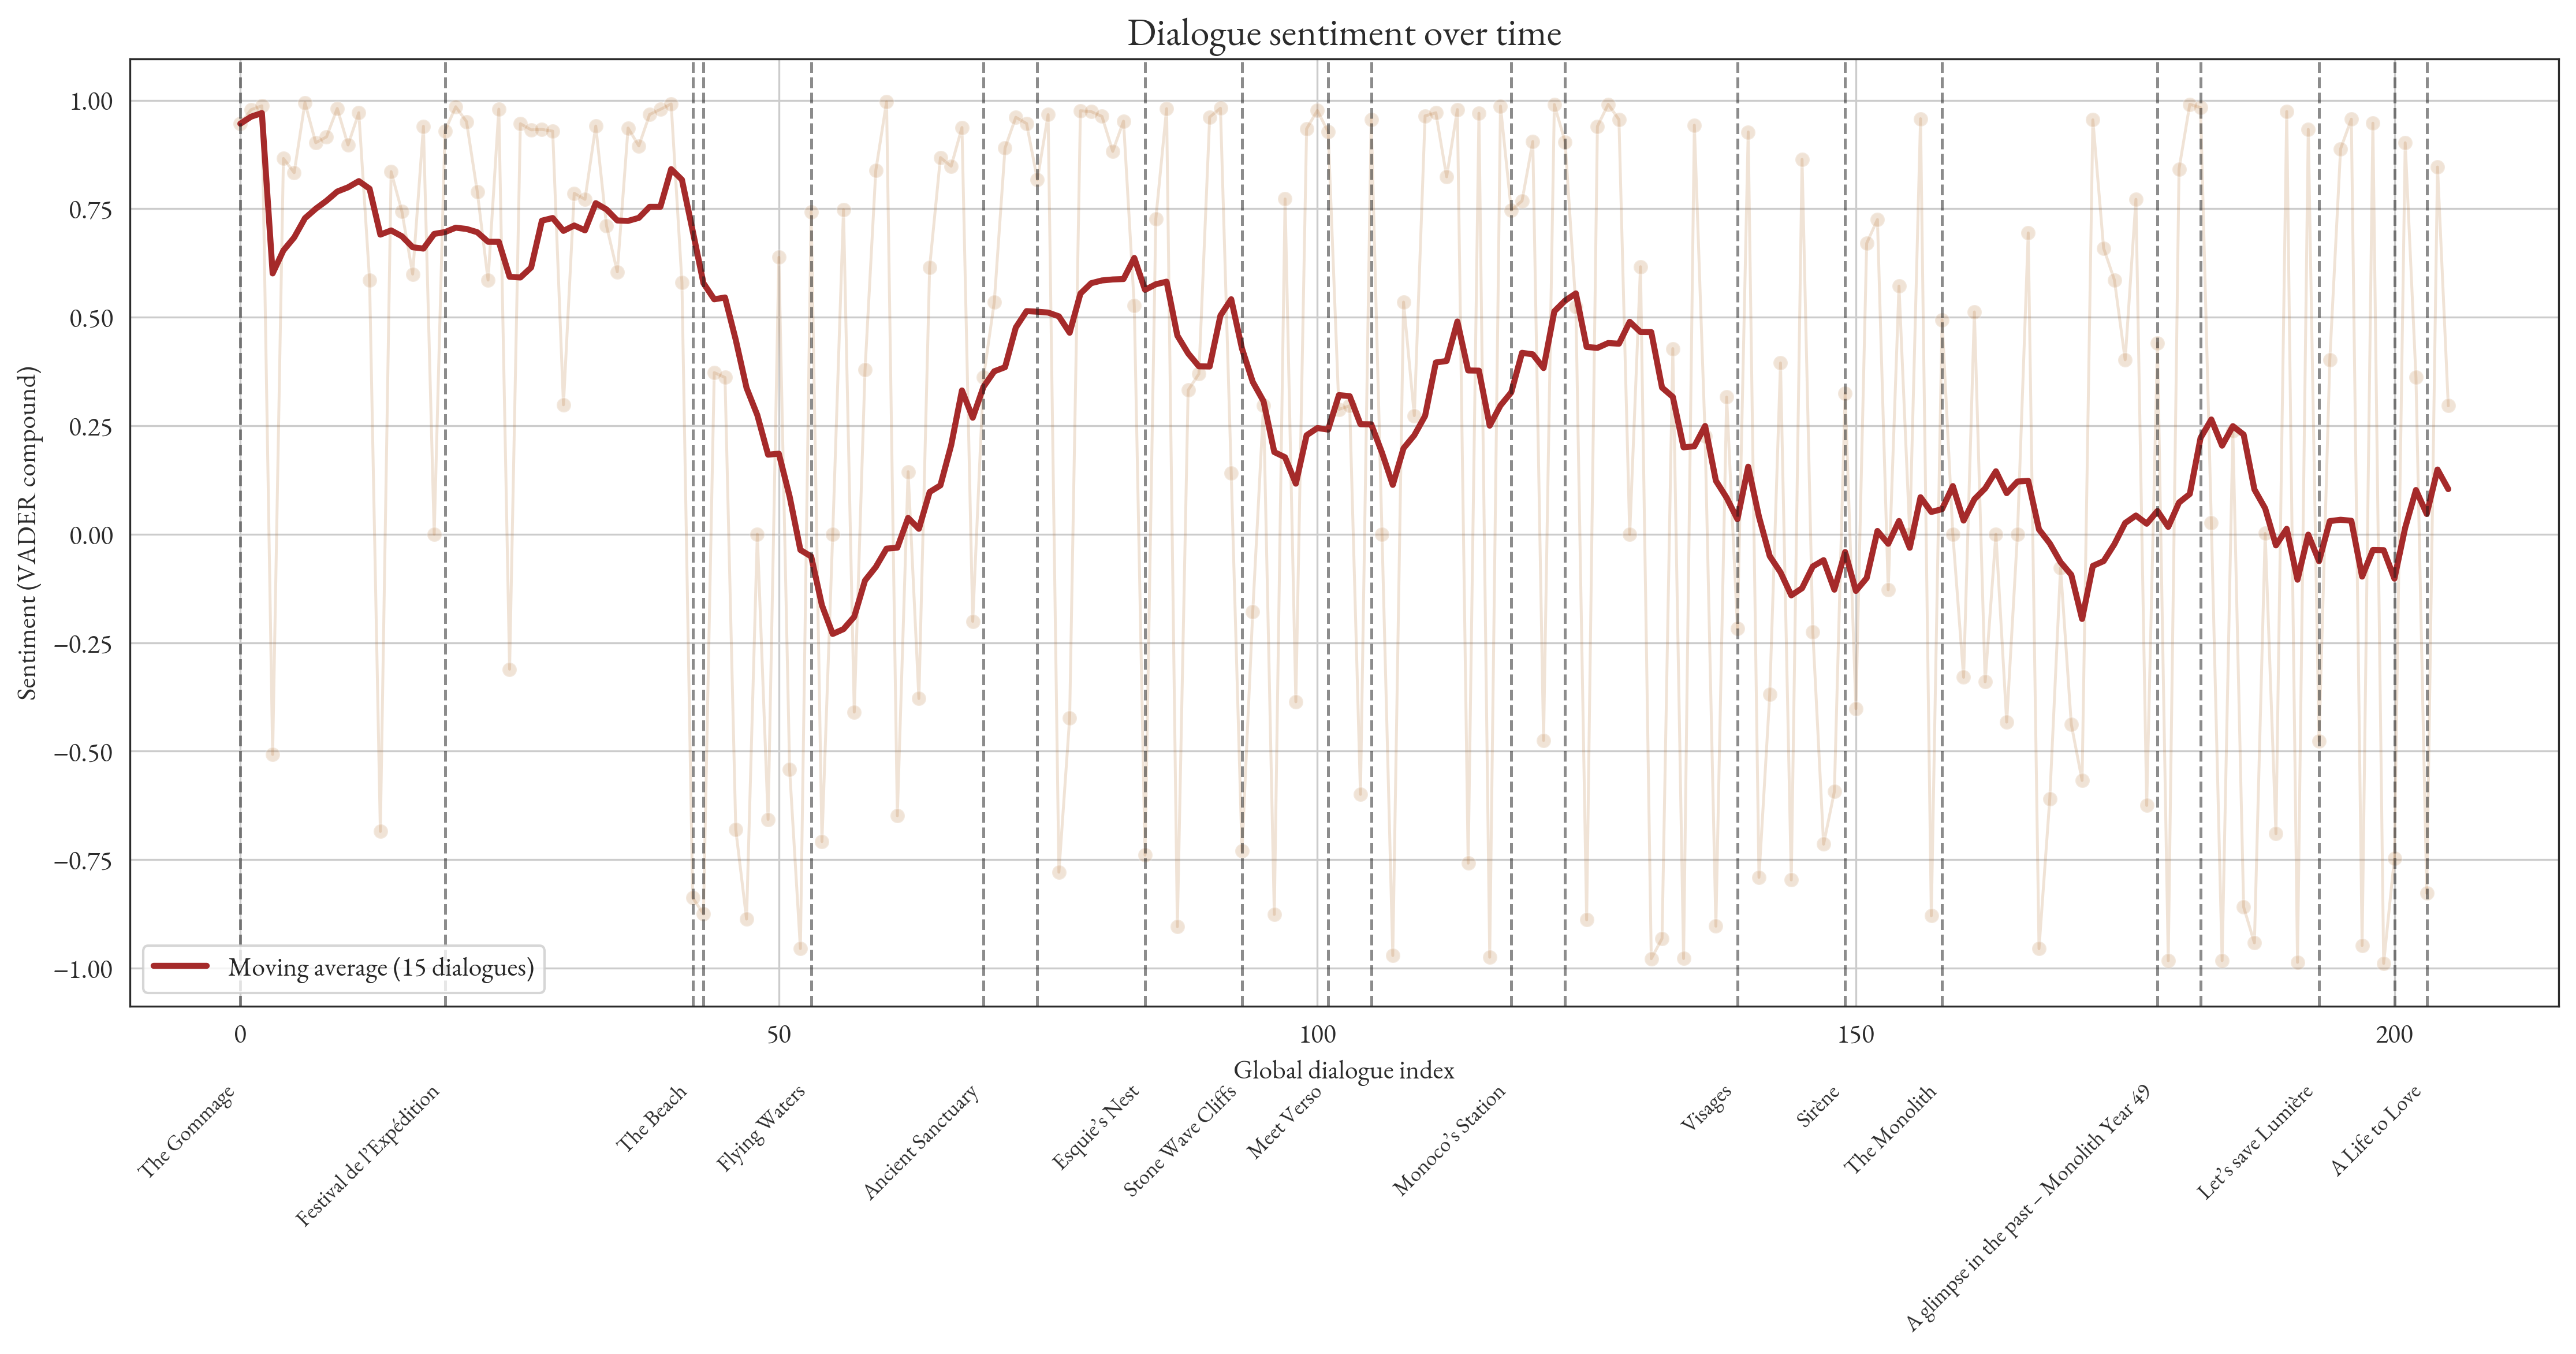

In [103]:
sia = SentimentIntensityAnalyzer()

global_ids = []
current_global_id = -1
last_key = None

for _, row in df.iterrows():
    key = (row["chapter"], row["dialogue_index"])
    if key != last_key:
        current_global_id += 1
        last_key = key
    global_ids.append(current_global_id)

df["global_dialogue_index"] = global_ids

dialogue_rows = []

for g_idx, group in df.groupby("global_dialogue_index", sort=False):
    dialogue_text = " ".join(group["line"])
    sentiment_score = sia.polarity_scores(dialogue_text)["compound"]
    chapter = group["chapter"].iloc[0]

    dialogue_rows.append({
        "global_dialogue_index": g_idx,
        "chapter": chapter,
        "sentiment": sentiment_score
    })

df_dialogue = pd.DataFrame(dialogue_rows)

gommage_red = "#A52A2A"
bronze_color = "#b87333"
dark_bg = "#2b2b2b"
line_color = "#1a1a1a"
plt.figure(figsize=(15, 8), dpi=300)
ax = plt.gca()

sns.lineplot(
    x="global_dialogue_index",
    y="sentiment",
    data=df_dialogue,
    marker="o",
    linewidth=1.2,
    alpha=0.2,
    color=bronze_color,
    ax=ax,
)

window_size = 15

df_dialogue["sentiment_ma"] = (
    df_dialogue["sentiment"]
    .rolling(window=window_size, min_periods=1)
    .mean()
)

sns.lineplot(
    x="global_dialogue_index",
    y="sentiment_ma",
    data=df_dialogue,
    linewidth=2.5,
    label=f"Moving average ({window_size} dialogues)",
    color=gommage_red,  # Oro
    ax=ax,
)

chapter_change_indices = df_dialogue.index[
    df_dialogue["chapter"] != df_dialogue["chapter"].shift()
].tolist()

y_min = min(
    df_dialogue["sentiment"].min(),
    df_dialogue["sentiment_ma"].min()
)
label_y = y_min - 0.07

min_spacing = 8
last_label_x = -9999

for idx in chapter_change_indices:
    x_val = df_dialogue.loc[idx, "global_dialogue_index"]
    chapter_name = df_dialogue.loc[idx, "chapter"]


    ax.axvline(
        x=x_val,
        color=line_color,
        linestyle="--",
        alpha=0.5,
        linewidth=1.2
    )

    if x_val - last_label_x >= min_spacing:
        ax.text(
            x_val,
            label_y - 0.2,
            chapter_name,
            rotation=45,
            verticalalignment="top",
            horizontalalignment="right",
            fontsize=9,
            color=dark_bg
        )
        last_label_x = x_val

ax.set_title("Dialogue sentiment over time", fontsize=14, color=dark_bg, fontproperties=font_prop)
ax.set_xlabel("Global dialogue index", fontsize=11, color=dark_bg, fontproperties=font_prop)
ax.set_ylabel("Sentiment (VADER compound)", fontsize=11, color=dark_bg, fontproperties=font_prop)

ax.tick_params(colors=dark_bg)
for spine in ax.spines.values():
    spine.set_edgecolor(dark_bg)

plt.tight_layout()
plt.show()

We can observe that the sentiment of dialogues fluctuates throughout the script and a general downward trend can be seen as the story unfolds. There seem to be 3 major dips in sentiment, the first one around chapters 3/4 (_The Beach_/_Spring Meadows_), the second one centered on _Stone Wave Cliffs_ and the third one between chapters 13 and 14 (_Old Lumière_ and _Visages_). These dips are expected since they correspond to the Expedition being almost entirely destroyed, Gustave's death, and the revelation about Verso's family respectively.